In [3]:
%matplotlib inline
from ml import plots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
plots.set_plot_style()
discrete_cmap = LinearSegmentedColormap.from_list('discrete', colors = [(0.8, 0.2, 0.3), (0.98, 0.6, 0.02), (0.1, 0.8, 0.3), (0, 0.4, 0.8), ], N=4)


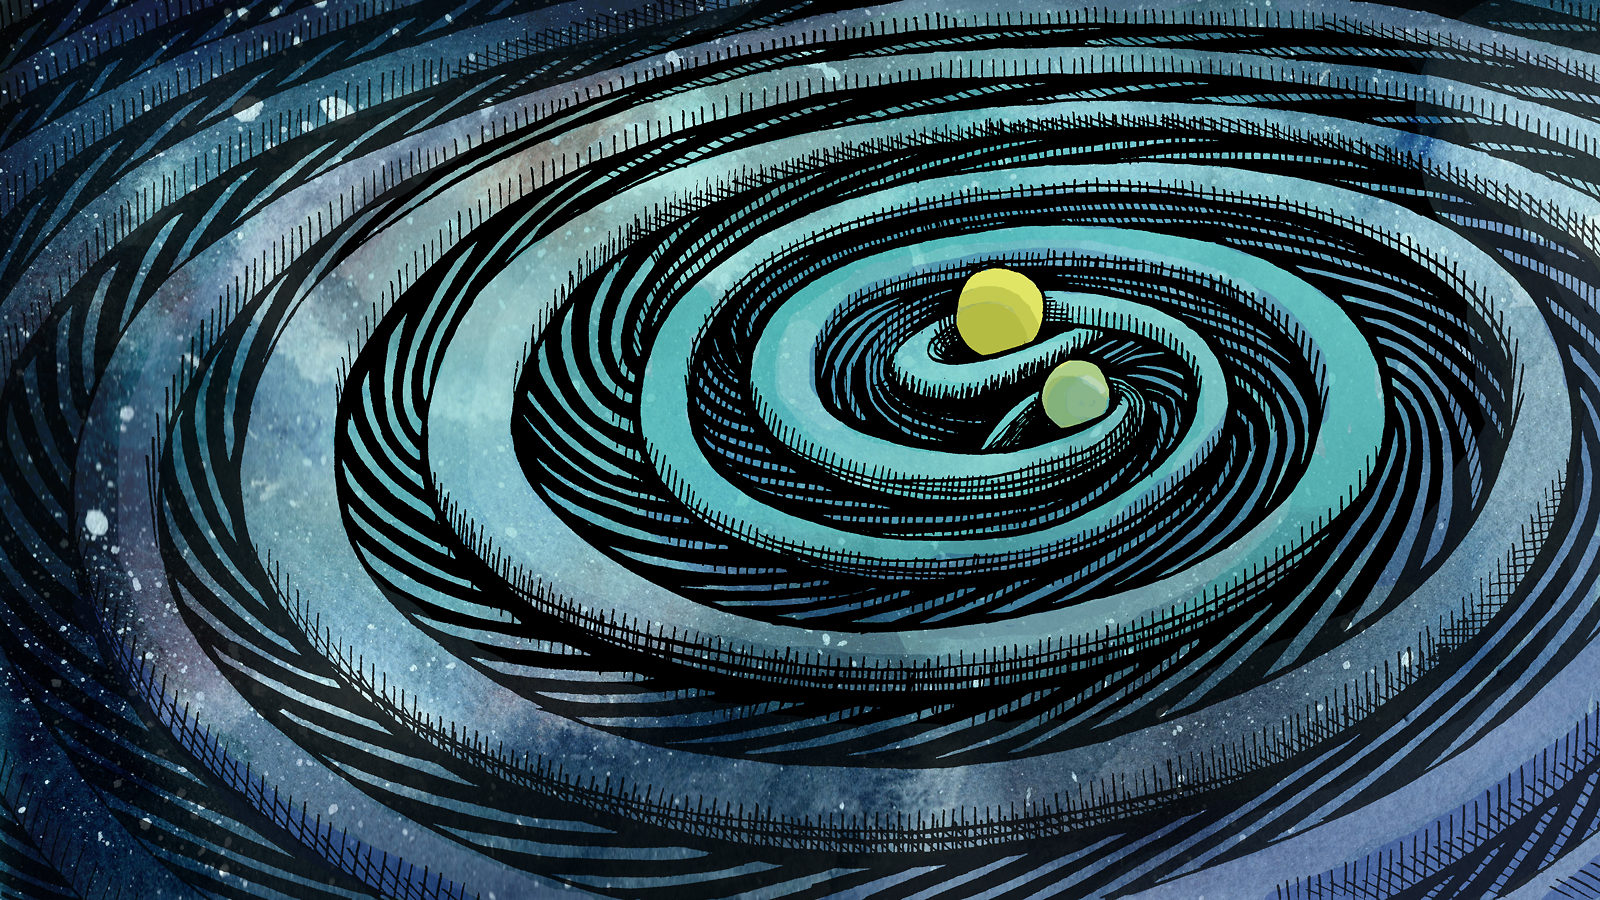

# Kolloquium

### Das Gravitationswellen-Fenster ins Universum

Dienstag den 5.12 um 16:30 im HG2 HS2.

Gehalten von Dr. Dominik Martin Elsässer.

# Neural Networks and Deep Learning

Most of this material was heavily inspired by http://cs231n.github.io/. Stanfords CNN for Image Recognition lecture.


## Linear Classification II

Previously we talked about classification using a linear function $f(x): \mathbb{R}^{p} \to \mathbb{R}$ and least-square regression.

Recall the linear function dependent on the parameter vector $\beta$


$$
f(x)= \hat{y} =  \hat{\beta}_0 + \sum_{j=1}^p x_j \hat{\beta}_j
$$


$$
f(x)= \hat{y} =  x^T \mathbf{\beta}
$$

where $\beta = (\beta_0, \beta_1, \beta_2, \ldots, \beta_p)$ and $x = (1, x_1, x_2, \ldots, x_p)$.

We minimized the residual sum of squares using matrix multiplication.

$$
RSS(\beta) = (\mathbf{y} - \mathbf{X} \beta)^T (\mathbf{y} - \mathbf{X} \beta )
\Rightarrow \hat{\beta} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$


In order to perform the classification we had to define the classification function 

$$
\hat{y} = \begin{cases}
\text{Yes}, & \text{if $ f(x) \gt 0.5$} \\
\text{No}, & \text{if $ f(x) \le 0.5$}
\end{cases}
$$ 

Now we encode the class label directly into the function. Given a classification problem with $K$ different classes we want $f(x): \mathbb{R}^{p} \to \mathbb{R}^K$ to return a vector of length $K$. Instead of finding the parameters in a vector $\beta$ we use a $p \times K$ matrix $\mathbf{W}$

$$
f(x) = \hat{y} =   x \cdot \mathbf{W}
$$

At this point we could again minimize a modified version of the RSS or the SVM loss. This time however we want to be able to have a more *probabilistic* interpretation of the loss function.

We use a new loss function called the __cross-entropy loss__. Also known as logistic loss. Given two probability density functions $p$ and $q$ over the same probabilistic space,  cross entropy is defined as

$$
H_{\times}(p, q) =     -\sum _{x} p(x)\,\log q(x).\!
$$

The cross entropy gives smaller values for similar distributions $q$ and $p$.
In case of classification problems $p$ is the true distribution of classes for a given $x$ and $q(x)$ the estimated distribution as produced by our machine learner. 

In the example below we look at $p$ for the digits dataset. As one example in the dataset can be just one digit, the $p$ vector has only a single non-zero entry. 

If a classifier produces the same distribution for the dataset we have perfect classification.

True (discrete) probability distributions.
[0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0]


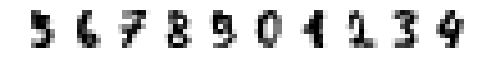

In [4]:
from sklearn.datasets import load_digits
from sklearn import preprocessing
X, y = load_digits(return_X_y=True)

y = preprocessing.LabelBinarizer().fit_transform(y)

print('True (discrete) probability distributions.')

fig, axs = plt.subplots(1, 10, figsize=(8, 8))
for i, x_i in enumerate(X[5:15]):
    ax = axs[i]
    img = x_i.reshape(8, 8)
    ax.imshow(img, cmap='gray_r', interpolation='nearest')
    ax.axis('off')
    print(y[i+5])

We want our estimated probabilities for the distribitution of class labels to be as close to the true distribution as possible. The result of our function $f(x)$ does not produce probability estimates. We need to *transform the results to probabilities* using the so called __softmax__ function

$$
q_k(x) =  \frac{e^{f_{k}(x)}} {∑_j e^{f_j(x)}}
$$

where the index $j \in \{1, \ldots, K \}$ loops over all classes and $f_k$ is the prediction for class $k$.

In shorter words: A classifier using cross entropy loss with softmax produces probabilities for class memberships.

Below we implement the softmax function and the loss function which uses a weight matrix $\mathbf{W}$ to compute the loss of the entire dataset

In [5]:
from sklearn.preprocessing import label_binarize
from sklearn.datasets import load_digits
np.random.seed(1)

X, y = load_digits(return_X_y=True)


ones = np.ones(shape=(len(X), 1))
X = np.hstack([ones, X])

# we have 10 classes and p attributes, digits from 0 to 9 and 64 pixels
K = 10
p = 64 

# include the bias into the weight matrix
W = np.random.normal(size=(p+1, K))

y = label_binarize(y, range(0, 10))
y

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [6]:
# softmax function shifted to zero so no numerical isntalbilities arise.
def softmax(f):
    f_shifted = f - f.max()
    p = np.exp(f_shifted).T/np.sum(np.exp(f_shifted), axis=1)
    return p.T

# loss for the entire training set
def loss_cross_ent(X, y, W):
    f = X@W
    q = softmax(f)
    l = -np.sum(y*np.log2(q), axis=1)
    return l.mean() # the mean over all samples in the batch/dataset

loss_cross_ent(X, y, W)

147.43958748430913

Now we need to find those weights in $\mathbf{W}$ which minimize the loss function. One way to minimize this is to randomly search for matrix entries until we get a better loss function. But thats obviously not very smart. 

In [7]:
def random_search(X, y, loss_function, max_iter=10000,):
    bestloss = np.inf
    
    # we have 10 classes and p attributes, digits from 0 to 9 and 64 pixels
    K = y.shape[1]
    p = X.shape[1]
    
    #save all losses
    losses = []
    
    #start with a random weight matrix
    W = np.random.normal(size=(p, K)) * 0.01
    for i in tqdm(range(max_iter)):
        # choose a random direction
        W_new = np.random.normal(size=(p, K)) *  0.01
        loss = loss_function(X, y, W_new)
        losses.append(loss)
        if (loss < bestloss):
            W = W_new
            bestloss = loss
    return losses
        
max_iter = 5000
losses_random = random_search(X, y, loss_cross_ent, max_iter=max_iter)

100%|██████████| 5000/5000 [00:15<00:00, 322.61it/s]


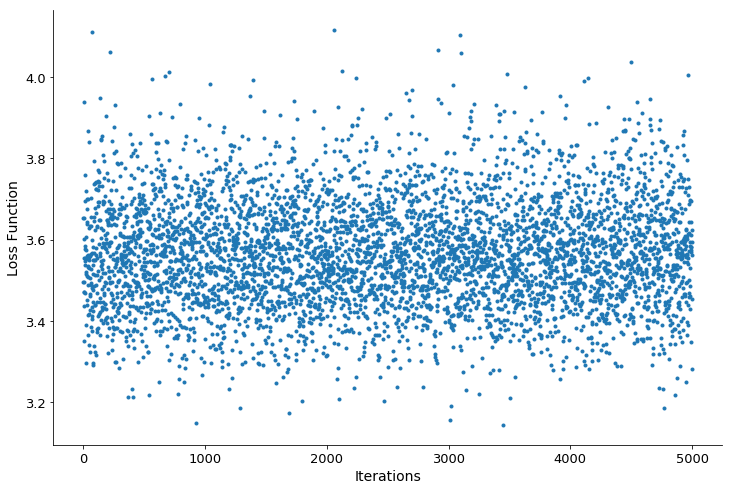

In [8]:
plt.plot(range(max_iter), losses_random, '.')
plt.xlabel('Iterations')
plt.ylabel('Loss Function')
None

Like in all problems we discussed before, it is actually computationally infeaseble to find the global optimum. We can again try a local search to find a local optimum. Again this is not a show-stopper in real-life situation. Often finding a local optimum suffices. Sometimes the problem can be reformulated to convex in which case the local optimizer is guaranteed to find the global optimum. 

Below we try an incremental approach. Which optimizes in a local neighbourhood of $\mathbf{W}$. We keep the best $\mathbf{W}$ we found in the previous iterations and only add a random direction to it.


In [9]:
def random_descent(X, y, loss_function, max_iter=10000, step_size=0.01):
    bestloss = np.inf
    
    # we have 10 classes and p attributes, digits from 0 to 9 and 64 pixels
    K = y.shape[1]
    p = X.shape[1]
    
    #save all losses
    losses = []
    
    #start with a random weight matrix
    W = np.random.normal(size=(p, K)) * step_size
    for i in tqdm(range(max_iter)):
        # choose a random direction
        W_new = W + np.random.normal(size=(p, K)) *  step_size
        loss = loss_function(X, y, W_new)
        losses.append(loss)
        if (loss < bestloss):
            W = W_new
            bestloss = loss
    return losses
        
max_iter = 2500
losses_random = random_descent(X, y, loss_cross_ent, max_iter=max_iter)

100%|██████████| 2500/2500 [00:07<00:00, 322.45it/s]


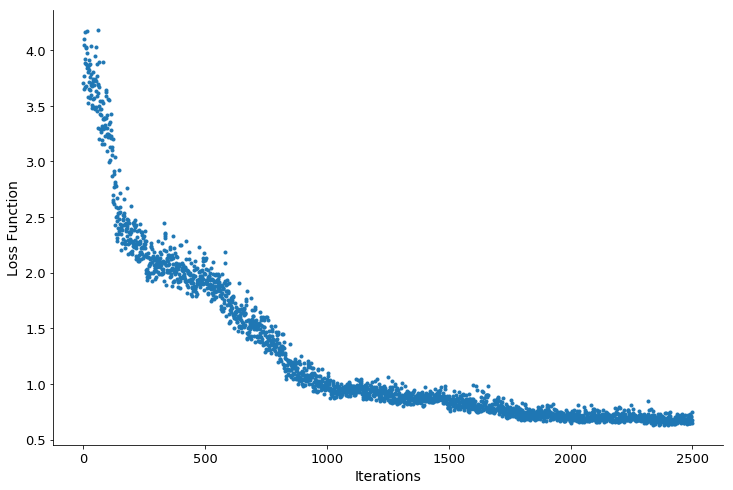

In [10]:
plt.plot(range(max_iter), losses_random, '.')
plt.xlabel('Iterations')
plt.ylabel('Loss Function')
None

In each step we shoose a random direction to optimize to. We can be smarter about it by following the gradient of the loss function in each iteration. The loss function will converge much faster. 

The gradient has to be computed with respect to our weight matrix $\mathbf{W}$
$$
L = H_{\times}(p, q) =     -\sum _{k} p_k\,\log q_k  =  -\sum _{k} p_k\,\log \left( \frac{e^{f_{k}(x)}} {∑_j e^{f_j(x)}} \right)
$$

where 

$$
f = \mathbf{W} \cdot x\, .
$$

We can build the derivative using the chain rule.

$$
\frac{\rm{\partial} L }{\rm{\partial} w} = \frac{\rm{\partial} L }{\rm{\partial} q} \frac{\rm{\partial} q }{\rm{\partial} f}\frac{\rm{\partial} f }{\rm{\partial}w}
$$

Note that derivatives of vectors always have to take the index into account. 
Or you can build the Jacobian. 


\begin{align}
\frac{\rm{\partial} L }{\rm{\partial} f_i} =& - \sum_k y_k \frac{\rm{\partial} \log q_k }{\rm{\partial} f_i} \\
=&- \sum_k y_k \frac{1}{q_k}\frac{\rm{\partial}q_k }{\rm{\partial} f_i} \\
&\vdots \; \; \text{Übungsaufgabe} \\
=& p_i - y_i
\end{align}

We use the computed gradient in the code to compute the update to the weight matrix $\mathbf{W}$


        W = W - dW * step_size
        
The step size, or learning rate controls how far we go down the gradient in each step.


In [11]:
def gradient(W, X, y):
    f = X@W
    p = softmax(f)
    dh = (p - y)
    dW = ( X.T@dh ) / dh.shape[0]
    return dW

def gradient_descent(X, y, loss_function, max_iter=10000, step_size=0.01):
    bestloss = np.inf
    
    # we have 10 classes and p attributes, digits from 0 to 9 and 64 pixels
    K = y.shape[1]
    p = X.shape[1]
    
    #save all losses
    losses = []
    #start with a random weight matrix
    W = np.random.normal(size=(p, K)) * step_size
    for i in tqdm(range(max_iter)):
        W = W - gradient(W, X, y) * step_size
        loss = loss_function(X, y, W)
        losses.append(loss)
        
    return losses, W




In [12]:
X, y = load_digits(return_X_y=True)

#add biases to matrix
ones = np.ones(shape=(len(X), 1))
X = np.hstack([ones, X])

y = label_binarize(y, range(0, 10))
y.shape

p = 65
K = 10
W = np.random.normal(size=(p, K))

losses, W = gradient_descent(X, y, loss_cross_ent, max_iter=max_iter)

100%|██████████| 2500/2500 [00:13<00:00, 181.40it/s]


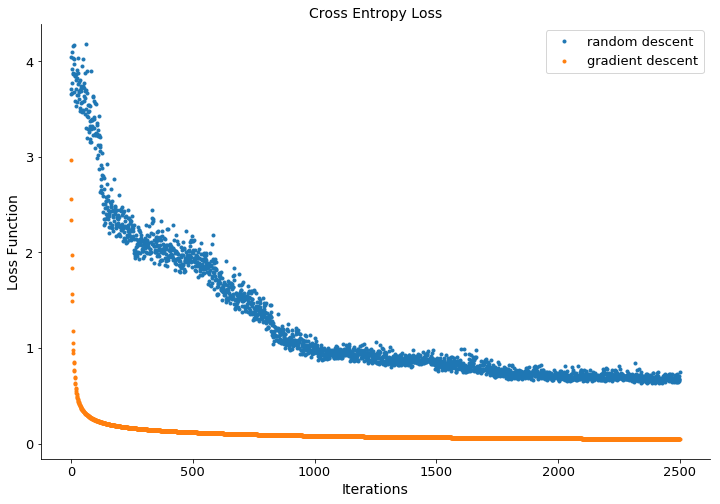

In [13]:
plt.plot(range(max_iter), losses_random, '.', label='random descent')
plt.plot(range(max_iter), losses, '.', label='gradient descent')
plt.xlabel('Iterations')
plt.ylabel('Loss Function')
plt.legend()
plt.title('Cross Entropy Loss')
None

100%|██████████| 200/200 [00:01<00:00, 138.69it/s]


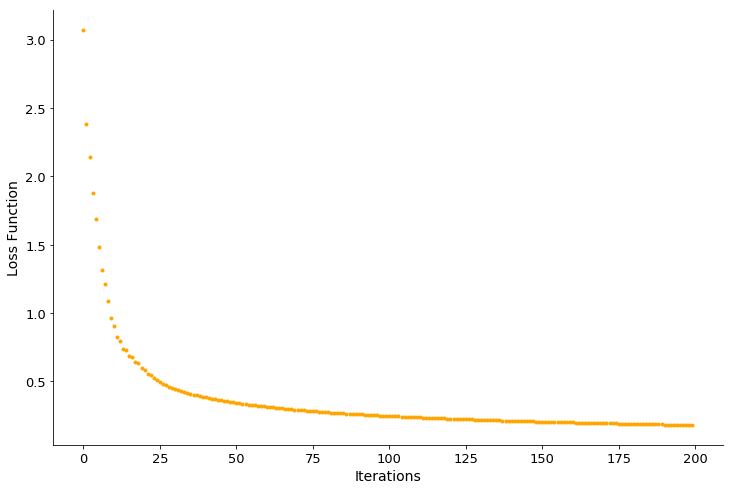

In [14]:
losses, W = gradient_descent(X, y, loss_cross_ent, max_iter=200)
plt.plot(range(200), losses, '.', label='gradient descent', color='orange')
plt.xlabel('Iterations')
plt.ylabel('Loss Function')
None

We just implemented the so called SoftMax classifier. This classifier is non-linear.
While the simple matrix multiplication $f = \mathbf{X} \mathbf{W}$ is linear , the application of the softmax function certainly is not. Our prediction vector is given by applying a non-linear function to the output of $f$

$$
p = q(f(x)) = q(x \cdot W)
$$

Below we apply this classifier to some test data. Clearly this on non-linear step does not suffice to classify non-linear data like the two spirals.

In [15]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1500, n_features=2, center_box=(-5, 5), centers=3, cluster_std=0.3, random_state=0)

#add biases to matrix
ones = np.ones(shape=(len(X), 1))
X_b = np.hstack([ones, X])
y_b = label_binarize(y, range(0, 3))

losses, W = gradient_descent(X_b, y_b, loss_cross_ent, max_iter=150)

100%|██████████| 150/150 [00:00<00:00, 749.76it/s]


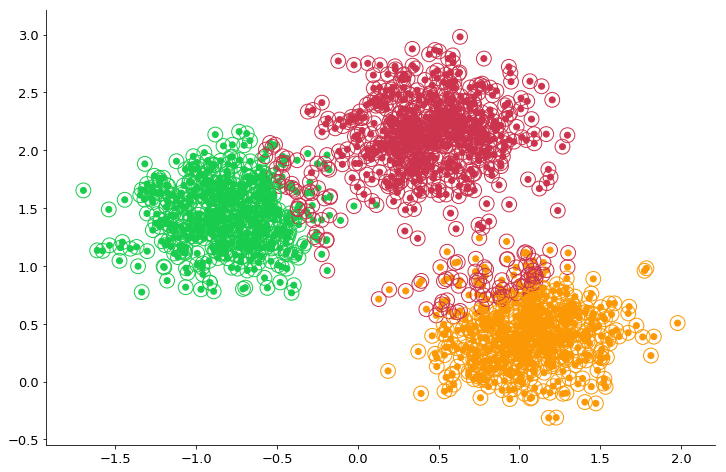

In [16]:
prediction = np.argmax(softmax(X_b@W), axis=1)
plt.scatter(X[:,0], X[:, 1], c=discrete_cmap(y))
plt.scatter(X[:,0], X[:, 1], facecolor='',s=220,  edgecolors=discrete_cmap(prediction))

In [17]:
X, y = plots.twospirals(n_samples=300)

#add biases to matrix
ones = np.ones(shape=(len(X), 1))
X_b = np.hstack([ones, X])
y_b = label_binarize(y, range(0, 3))

losses, W = gradient_descent(X_b, y_b, loss_cross_ent, max_iter=150)

100%|██████████| 150/150 [00:00<00:00, 1090.37it/s]


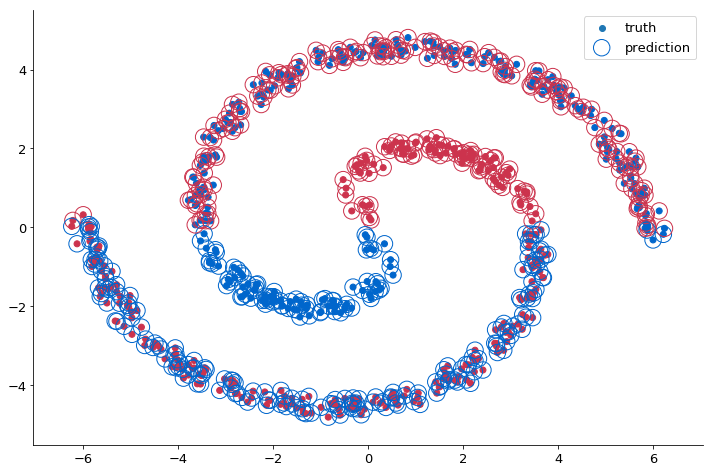

In [20]:
X, y  = plots.twospirals(n_samples=300)
X_b = np.hstack([ones, X])
y_b = label_binarize(y, range(0, 3))

prediction = np.argmax(softmax(X_b@W), axis=1)
prediction = np.choose(prediction, [3, 0, 2])


plt.scatter(X[:,0], X[:, 1], c=y, cmap=discrete_cmap, label='truth')
plt.scatter(X[:,0], X[:, 1], facecolor='',s=270,  edgecolors=discrete_cmap(prediction), label='prediction')
plt.legend()

### Neural Networks (Multi Layer Perceptron)

We use another abstraction to describe the linear classification we used above. 
We started with an input image of $8 \times 8$ pixels. We flatten it to get a single vector $x_i$ with $64$ entries.
In the next step we multiply the vector with a matrix $W$ with dimensions $64 \times 10$ and get a result vector of length 10. The following image shows this process in a network like manner. 

<img src="./ml/images/nn.png">

Neural networks use some special slang to describe their architecture. The column of blue dots, i.e. the matrix multiplication, is called a layer. Depending on context this will be called a *hidden layer* or *fully connected layer*. The input and outputs are called the *input* and *output layer* respectively. The white box labeled as Softmax  is called *activation function*


<img src="./ml/images/nn_wording.png">


We can extend the previous idea further by applying more than one layer of matrix multiplications.

$$
p = q_2(q_1(x \cdot W_1), W_2)
$$

Each entry in the weight matrices $W_1$ and $W_2$ are *learnable* parameters. The matrices have dimension $n_{\text{in}} \times n_{\text{out}}$ (neglecting biases). In the single layer network we trained above we had a single layer with 640 free parameters to optimize. In the case  of two full layers we would have twice as many. 


<img src="./ml/images/nn_two.png">


The method of finding the gradient for such a complex function is actually not different from what we did before. As long as the Loss function is a linear function with respect to the number of samples. This holds for loss functions like the mean square error, the cross entropy loss or the SVM loss. 

$$
L = \frac 1 N \sum_n^N L_i
$$

As long as the activation functions and the loss function  are differentiable the gradient can be calculated either numerically or analytically using __backpropagation__. Which essentially requires nothing more than recursive application of the chain rule of derivatives. In the example above we used backpropagation on a single layer to calculate the gradient. 

Below we use the sklearn __multi-layer perceptron__ to classify the spiral data. 

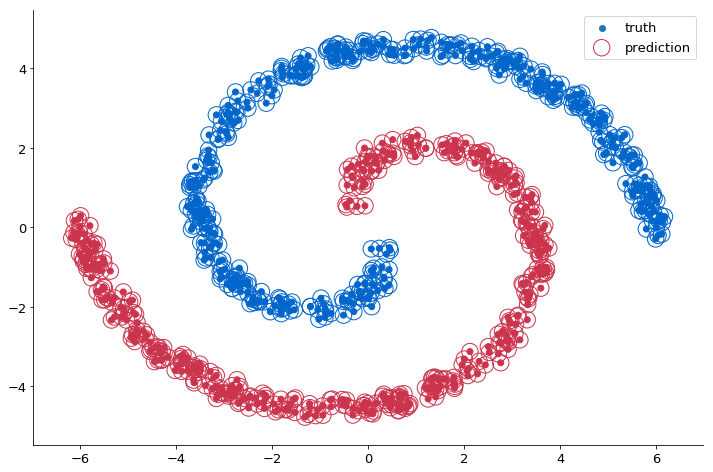

In [21]:
from sklearn.neural_network import MLPClassifier
np.random.seed(0)
X, y  = plots.twospirals(n_samples=400)

clf = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=500)
clf.fit(X, y)

X, y  = plots.twospirals(n_samples=400)
prediction  = clf.predict(X)

plt.scatter(X[:,0], X[:, 1], c=y, cmap=discrete_cmap, label='truth')
plt.scatter(X[:,0], X[:, 1], facecolor='',s=270,  edgecolors=discrete_cmap(prediction), label='prediction')
plt.legend()

We initialized the MLP with two hidden layers of size 10. As our dataset is two dimensional, the input layer has size 2. The two layers are represented as matrices of size $2 \times 10$ which means we have 40 matrix entries (plus biases) to optimize in total. 

The more layers and nodes a network has, the higher the representation power. In this case a simple 2 layer network does not suffice to represent the spiral data. 


http://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html

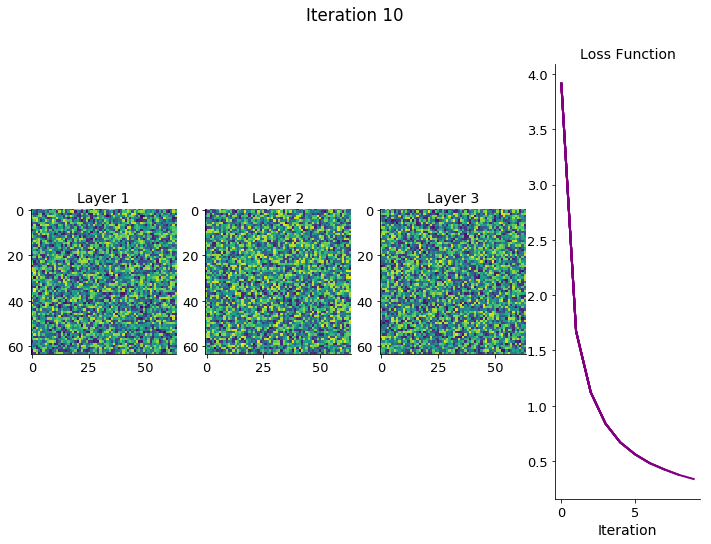

In [22]:
from IPython import display
from sklearn.metrics import confusion_matrix
import time
import warnings
warnings.filterwarnings('ignore')

fig, [ax1, ax2, ax3, ax4] = plt.subplots(1, 4)

X, y  = load_digits(return_X_y=True)

last = 0
for i in range(10):
    mlp = MLPClassifier(hidden_layer_sizes=(64,64,64), max_iter=i+1, random_state=43, solver='sgd',)
    mlp.fit(X, y)
    
    if i > 0 :
        plt.suptitle('Iteration {}'.format(i+1))
        
        ax1.set_title('Layer 1')
        ax2.set_title('Layer 2')
        ax3.set_title('Layer 3')
        ax4.set_title('Loss Function')
        ax4.set_xlabel('Iteration')

        diff_0 = np.asarray(mlp.coefs_[0]) 
        diff_1 = np.asarray(mlp.coefs_[1]) 
        diff_2 = np.asarray(mlp.coefs_[2]) 
        diff_3 = np.asarray(mlp.coefs_[3]) 
        

        ax1.imshow(diff_0, )
        ax2.imshow(diff_1, )
        ax3.imshow(diff_2, )
        ax4.plot(mlp.loss_curve_, color='purple')
    
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    last_0 = np.asarray(mlp.coefs_[0])
    last_1 = np.asarray(mlp.coefs_[1])
    last_2 = np.asarray(mlp.coefs_[2])
    last_3 = np.asarray(mlp.coefs_[3])
    
        
    
plt.close()

    


### Activation Functions

There are a range of activation functions to choose from. The Softmax functions we used for linear classification is often used in the final/output layer of a network to produce probability estimates.
An activation function has to be non-linear. Otherwise layers in the network could be merged together into one single matrix operation. Sometimes activation functions are also called non-linearities

##### Sigmoid 

$$
g(x) = \frac{1}{1 + e^{-x}}
$$

The sigmoid function squashes values into range between 0 and 1.
It has been very popular for neural networks in the past but has recently fallen out of favor because it does not behave well when using gradient descent. 

$$
\rm{d}g(x) = \frac{e^x}{\left(1 + e^{x}\right)^2}
$$

As visible in the plot below the gradient becomes zero for large values of $x$.  Which leads to saturations in the gradient descent steps.

 



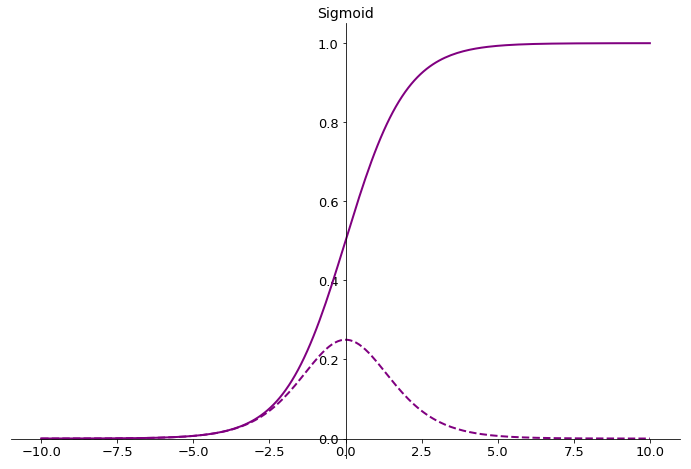

In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_gradient(x):
    return np.exp(x) / (1 + np.exp(x))**2


x = np.linspace(-10, 10, 200) 
plt.plot(x, sigmoid(x), color='purple')
plt.plot(x, sigmoid_gradient(x), color='purple', ls='--')
plt.gca().spines['left'].set_position(('data', 0.0))
plt.gca().spines['bottom'].set_position(('data', 0.0))

plt.title('Sigmoid')


##### Tangens hyperbolicus 

$$
g(x) = \tanh{x}
$$

The tangens hyperbolicus function behaves very similar to the sigmoid function. Its just a scaled version of it.


$$
\rm{d}g(x) = 1 - \tanh^2{x}
$$

The gradient also becomes zero for large values of $x$.  However the values of the $\tanh$ function are centered around zero which has some advantagous properties when compared to the sigmoid function.
 


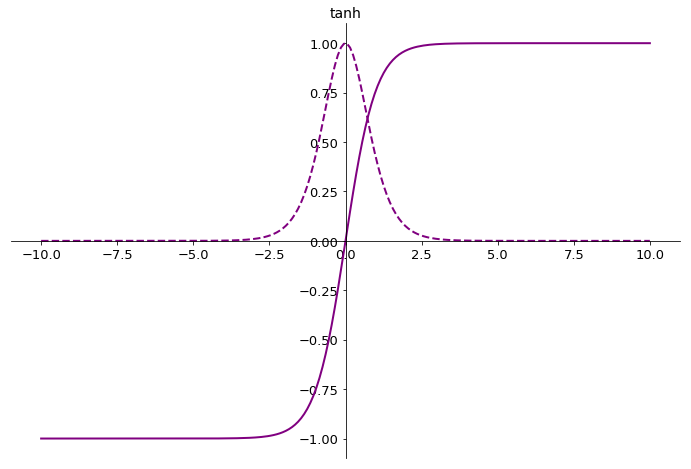

In [24]:
def tanh(x):
    return np.tanh(x)

def tanh_gradient(x):
    return 1 - tanh(x)**2


x = np.linspace(-10, 10, 200) 
plt.plot(x, tanh(x), color='purple')
plt.plot(x, tanh_gradient(x), color='purple', ls='--')
plt.gca().spines['left'].set_position(('data', 0.0))
plt.gca().spines['bottom'].set_position(('data', 0.0))

plt.title('tanh')

##### Rectified Linear Unit (ReLU)

$$
g(x) = \max{0, x}
$$

The ReLU function became very popular recently. It was used in some very image recognition networks. Evaluating the function is cheap and it often increases the speed of the gradient descent. See [Krizhevsky et al.](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf)


$$
\rm{d}g(x) = \begin{cases}
                1,  & \text{if $x > 0$} \\
                \text{undefined},  & \text{if $x = 0$} \\
                \text{0},  & \text{if $x < 0$} \\
\end{cases}
$$

The gradient is zero for value smaller than 0 and is discontinous. This can lead to a problem called 'dying neurons'.
The softplus function is a common alternative.


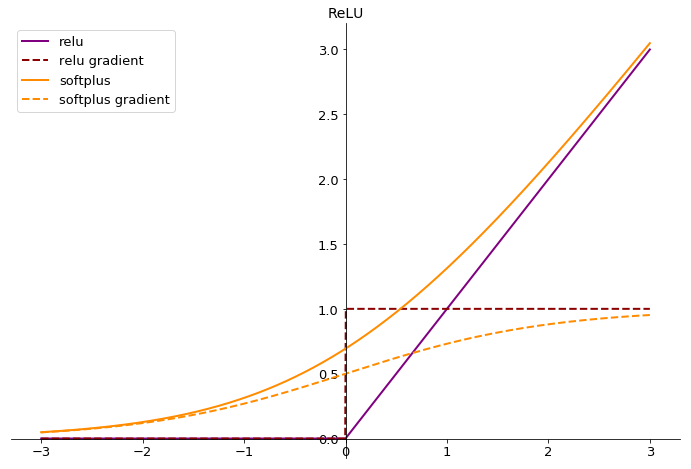

In [25]:
def relu(x):
    return np.maximum(0, x)

def relu_gradient(x):
    return np.clip(np.sign(x), 0, 1)

def softplus(x):
    return np.log(1 + np.exp(x))

def softplus_gradient(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-3, 3, 1000) 
plt.plot(x, relu(x), label='relu', color='purple')
plt.plot(x, relu_gradient(x), label='relu gradient', color='darkred', ls='--')
plt.plot(x, softplus(x), label='softplus', color='darkorange')
plt.plot(x, softplus_gradient(x), label='softplus gradient', color='darkorange', ls='--')
plt.gca().spines['left'].set_position(('data', 0.0))
plt.gca().spines['bottom'].set_position(('data', 0.0))
plt.title('ReLU')
plt.legend()

#### Regularization

We've seen how easily neural networks can overfit. We can try to avoid that using two techniques.

- Add a penalty term to the loss function.
- Add special regularization layers.

Adapting the loss function is a common method to avoid overfitting not only for neural networks. We have seen a similar idea for the SVM loss function.

A common approach is the  __L2__ regularization.

$$
L_r = L + \frac{1}{2} \lambda w^2
$$

It avoids strong changes in $w$ and creates more diffuse weight matrices.

So called __dropout layers__ randomly select neurons to activate during the training. Each iteration only optimizes a subset of neurons.

#### Convolutional Neural Nets for Image Recognition

The basic idea behind CNNs are simplifications made for handlin high dimensional inputs like high resolution images. 
Before the first fully connected layers are trained on the input data a so called convolution kernel is applied to the image. The parameters of this kernel are free to be optimized during training. The weights for each region in the image are shared however. This reduces the amount of parameters need to train a network and also leads to __translational invariance__.




![cnn.gif](ml/images/cnn.gif)

##### Neural Networks in practice
A few key points to take away:

 - The more layers the network the more powerful it becomes. However training might not converge or overfitting might occur.
 
 - The term neural network is a misnomer. Thats not how real brains work.
 
 - You need regularization to avoid overfitting.
 
 - The word *Deep* in *Deep Learning* refers to the number of hidden layers. No magic involved but a lot of hype.
 
 - Do not use the sigmoid activation. Use ReLU if you are unsure.


#### Software

Large networks require considerable computing power to optimize. Matrix computations are well suited for GPUs. The scikit-learn library does not support GPU computation out of the box. It also does not support convoluted neural networks.

There is a whole zoo of software libraries to train large neural networks. Here are some important ones.

##### Tensorflow

Developed by Google Inc. Maybe the most popular solution.

![graph_vis_animation.gif](./ml/images/graph_vis_animation.gif)


##### Keras

High-Level API build ontop of TF and CNTK.

<img width="50%" src="./ml/images/keras-logo-2018-large-1200.png">

###### CNTK

Micorsofts solution 
https://github.com/Microsoft/cntk

In [2]:
from IPython.display import HTML

HTML('<iframe width="660" height="415" src="https://www.youtube.com/embed/cf0JG0791P4" frameborder="0" gesture="media" allow="encrypted-media" allowfullscreen></iframe>')